In [38]:
from lib.constants import *
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import matplotlib.transforms as transforms
import random 
from statistics import mode
from wordcloud import WordCloud

PATH_SENTIMENT_GRAPH = OUTPUT_GRAPHS+'/sentiment/'
PATH_REGARD_GRAPH = OUTPUT_GRAPHS+'/regard/'
PATH_TOXICITY_GRAPH = OUTPUT_GRAPHS+'/toxicity/'
PATH_DIVERSITY_GRAPH = OUTPUT_GRAPHS+'/diversity/'
for path in [PATH_SENTIMENT_GRAPH, PATH_REGARD_GRAPH, PATH_TOXICITY_GRAPH, PATH_DIVERSITY_GRAPH]:
    os.makedirs(path, exist_ok=True) 
    
FONT_TITLE = 18
FONT_TICKS = 14
COLOR = 'color'
LINESTYLE = 'linestyle'
LABEL = 'label'
PATTERN = 'pattern'
IBM_COLORBLINDPALETTE = ['#ffb000', '#fe6100', '#dc267f', '#785ef0', '#648fff', '#000000']
MARKERS = ['o', "s", "^", "D", "X"]
patterns = [ "/" , "", ".","\\" , "|" , "-" , "+" , "x", "o", "O", "*"]

MODELS_GRAPHICS = {
    BERT_BASE : {
        LABEL: 'BERT Base',
        COLOR: '#ffb000', 
        LINESTYLE: '-',
        PATTERN: ""
    },
    BERT_LARGE : {
        LABEL: 'BERT Large',
        COLOR: '#ffb000', 
        LINESTYLE: '--',
        PATTERN: "/"
    },
    ROBERTA_BASE : {
        LABEL: 'RoBERTa Base',
        COLOR: '#41a326', 
        LINESTYLE: '-',
        PATTERN: ""
    },
    ROBERTA_LARGE : {
        LABEL: 'RoBERTa Large',
        COLOR: '#41a326', 
        LINESTYLE: '--',
        PATTERN: "/"
    },
    LLAMA3 : {
        LABEL: 'Llama 3',
        COLOR: '#785ef0', 
        LINESTYLE: '-',
        PATTERN: ""
    },
    LLAMA3_70B : {
        LABEL: 'Llama 3 (70b)',
        COLOR: '#785ef0', 
        LINESTYLE: '--',
        PATTERN: "/"
    },
    GEMMA3 : {
        LABEL: 'Gemma 3',
        COLOR: '#dc267f', 
        LINESTYLE: '-',
        PATTERN: ""
    },
    GEMMA3_27B : {
        LABEL: 'Gemma 3 (27b)',
        COLOR: '#dc267f', 
        LINESTYLE: '--',
        PATTERN: "/"
    },
    GEMINI_2_0_FLASH_LITE : {
        LABEL: "Gemini 2.0 Flash Lite",
        COLOR: '#fe6100', 
        LINESTYLE: '-',
        PATTERN: ""
    },
    GEMINI_2_0_FLASH : {
        LABEL: "Gemini 2.0 Flash",
        COLOR: '#fe6100', 
        LINESTYLE: '--',
        PATTERN: "/"
    },
    GPT4_MINI : {
        LABEL: 'GPT4o Mini',
        COLOR: '#648fff', 
        LINESTYLE: '-',
        PATTERN: ""
    },
    GPT4 : {
        LABEL: 'GPT4o',
        COLOR: '#648fff', 
        LINESTYLE: '--',
        PATTERN: "/"
    },
    DEEPSEEK: {
        LABEL: 'DeepSeek R1',
        COLOR: '#000000', 
        LINESTYLE: '-',
        PATTERN: ""
    },
    DEEPSEEK_673B: {
        LABEL: 'DeepSeek R1 (671b)',
        COLOR: '#000000', 
        LINESTYLE: '--',
        PATTERN: "/"
    }
}
    
PERSPECTIVE_MAP = {
    TOXICITY: { 
        LABEL: "Toxicity",
        COLOR: '#ffb000'
    }, 
    SEVERE_TOXICITY: { 
        LABEL: "Severe Toxicity",
        COLOR: '#fe6100'
    }, 
    INSULT: { 
        LABEL: "Insult",
        COLOR: '#dc267f'
    },  
    IDENTITY_ATTACK: { 
        LABEL: "Identity Attack",
        COLOR: '#785ef0'
    },  
    PROFANITY: { 
        LABEL: "Profanity",
        COLOR: '#648fff'
    }, 
    THREAT: { 
        LABEL: "Threat",
        COLOR: '#000000'
    }
}


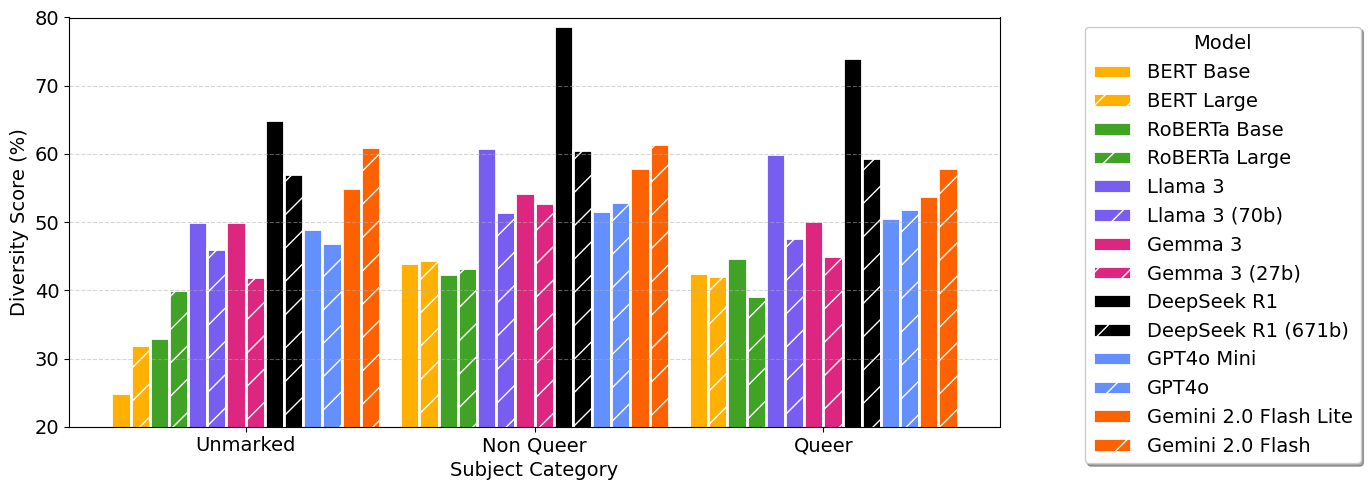

In [39]:
def get_diversity_score(models):
    diversity_scores = []

    for model in models:
        data = pd.read_csv(f"{OUTPUT_EVALUATION + model}.csv") 
        for subjCat in SUBJ_CATEGORIES:
            df = data[data[TYPE] == subjCat].dropna(subset=[PREDICTION])

            if subjCat == UNMARKED:
                word_list = df[PREDICTION].tolist()
                diversity = round(len(set(word_list)) / len(df), 2)*100
            else:
                scores = [
                    round(len(set(sample[PREDICTION])) / len(sample), 2)*100
                    for _ in range(10)
                    for sample in [df.sample(n=100, replace=False, random_state=random.randint(0, 10000))]
                ]
                diversity = np.mean(scores)
            diversity_scores.append([model, subjCat, diversity])
    df_scores = pd.DataFrame(diversity_scores, columns=['Model', 'Subject Category', 'Diversity Score'])
    
    fig, ax = plt.subplots(figsize=(12, 5))
    num_models = len(models)
    total_group_width = 0.93  # increase to make bars wider
    bar_width = total_group_width / num_models
    x_positions = np.arange(len(SUBJ_CATEGORIES))
    all_handles = []
    all_labels = []
    for i, model in enumerate(models):
        model_scores = df_scores[df_scores['Model'] == model]
        bars = ax.bar(x_positions + i * bar_width, 
                model_scores['Diversity Score'], 
                width=bar_width, 
                label=MODELS_GRAPHICS[model].get(LABEL), 
                color=MODELS_GRAPHICS[model].get(COLOR), 
                hatch=MODELS_GRAPHICS[model].get(PATTERN), 
                edgecolor='white',
                linewidth=2
            )
        all_handles.append(bars[0])
        all_labels.append(MODELS_GRAPHICS[model].get(LABEL))
        
    ax.set_xticks(x_positions + (total_group_width - bar_width) / 2)
    ax.set_xticklabels(SUBJ_CATEGORIES, fontsize=FONT_TICKS)
    ax.tick_params(axis='both', which='major', labelsize=FONT_TICKS)
    ax.set_xlabel("Subject Category", fontsize=FONT_TICKS)
    ax.set_ylabel("Diversity Score (%)", fontsize=FONT_TICKS)
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    plt.ylim(top=80) #ymax is your value
    plt.ylim(bottom=20) #ymin is your value
    plt.subplots_adjust(bottom=0.25)
    # Updated legend position
    fig.legend(
        all_handles,
        all_labels,
        title="Model",
        loc="center left",
        bbox_to_anchor=(0.9, 0.5),
        fancybox=True,
        shadow=True,
        ncol=1,  # stack vertically
        fontsize=FONT_TICKS,
        title_fontsize=FONT_TICKS
    )

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space on the right for legend
    plt.savefig(PATH_DIVERSITY_GRAPH + 'diversity.png', bbox_inches='tight')

# Call the function
get_diversity_score(MODEL_LIST_FULL)

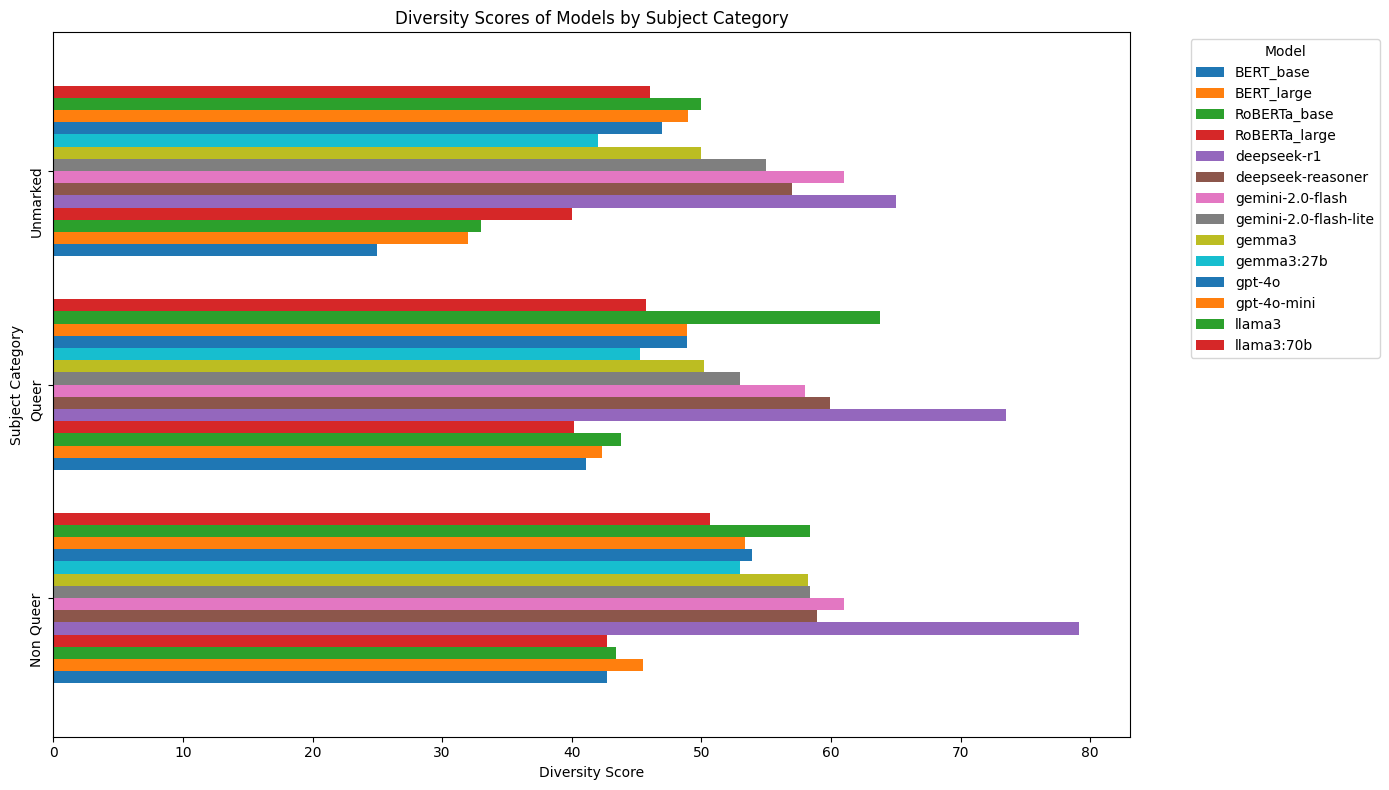

In [40]:
def get_diversity_score(models):
    diversity_scores = []

    for model in models:
        data = pd.read_csv(f"{OUTPUT_EVALUATION + model}.csv") 
        for subjCat in SUBJ_CATEGORIES:
            df = data[data[TYPE] == subjCat].dropna(subset=[PREDICTION])

            if subjCat == UNMARKED:
                word_list = df[PREDICTION].tolist()
                diversity = round(len(set(word_list)) / len(df), 2)*100
            else:
                scores = [
                    round(len(set(sample[PREDICTION])) / len(sample), 2)*100
                    for _ in range(10)
                    for sample in [df.sample(n=100, replace=False, random_state=random.randint(0, 10000))]
                ]
                diversity = np.mean(scores)
            diversity_scores.append([model, subjCat, diversity])
    df_scores = pd.DataFrame(diversity_scores, columns=['Model', 'Subject Category', 'Diversity Score'])
    #print(df_scores)
    df = df_scores

    # Pivot the dataframe to make the models as columns and subject categories as rows
    pivot_df = df.pivot(index='Subject Category', columns='Model', values='Diversity Score')

    # Plotting the horizontal bar graph with wider bars
    bar_width = 0.8  # wider bars
    ax = pivot_df.plot(kind='barh', figsize=(14, 8), width=bar_width)

    # Customizing the plot
    plt.title('Diversity Scores of Models by Subject Category')
    plt.xlabel('Diversity Score')
    plt.ylabel('Subject Category')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=90)  # rotate y-axis labels

    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # fig, ax = plt.subplots(figsize=(12, 6))
    # num_models = len(models)
    # bar_width = 0.8 / num_models  
    # x_positions = np.arange(len(SUBJ_CATEGORIES))
    # all_handles = []
    # all_labels = []
    # for i, model in enumerate(models):
    #     model_scores = df_scores[df_scores['Model'] == model]
    #     bars = ax.bar(x_positions + i * bar_width, 
    #             model_scores['Diversity Score'], 
    #             width=bar_width, 
    #             label=MODELS_GRAPHICS[model].get(LABEL), 
    #             color=MODELS_GRAPHICS[model].get(COLOR), 
    #             hatch=MODELS_GRAPHICS[model].get(PATTERN), 
    #             edgecolor='white',
    #             linewidth=2
    #         )
    #     all_handles.append(bars[0])
    #     all_labels.append(MODELS_GRAPHICS[model].get(LABEL))
        
    # ax.set_xticks(x_positions + (bar_width * (num_models / 2 - 0.5)))
    # ax.set_xticklabels(SUBJ_CATEGORIES, fontsize=FONT_TICKS)
    # ax.tick_params(axis='both', which='major', labelsize=FONT_TICKS)
    # ax.set_xlabel("Subject Category", fontsize=FONT_TICKS)
    # ax.set_ylabel("Diversity Score (%)", fontsize=FONT_TICKS)
    # ax.grid(axis="y", linestyle="--", alpha=0.5)
    # plt.ylim(top=80) #ymax is your value
    # plt.ylim(bottom=20) #ymin is your value
    # plt.subplots_adjust(bottom=0.25)
    # fig.legend(all_handles, all_labels, title="Model", loc="lower center", bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=4, fontsize=FONT_TICKS, title_fontsize=FONT_TICKS)

    # plt.tight_layout()
    # plt.savefig(PATH_DIVERSITY_GRAPH + 'diversity.png', bbox_inches='tight')

# Call the function
get_diversity_score(MODEL_LIST_FULL)

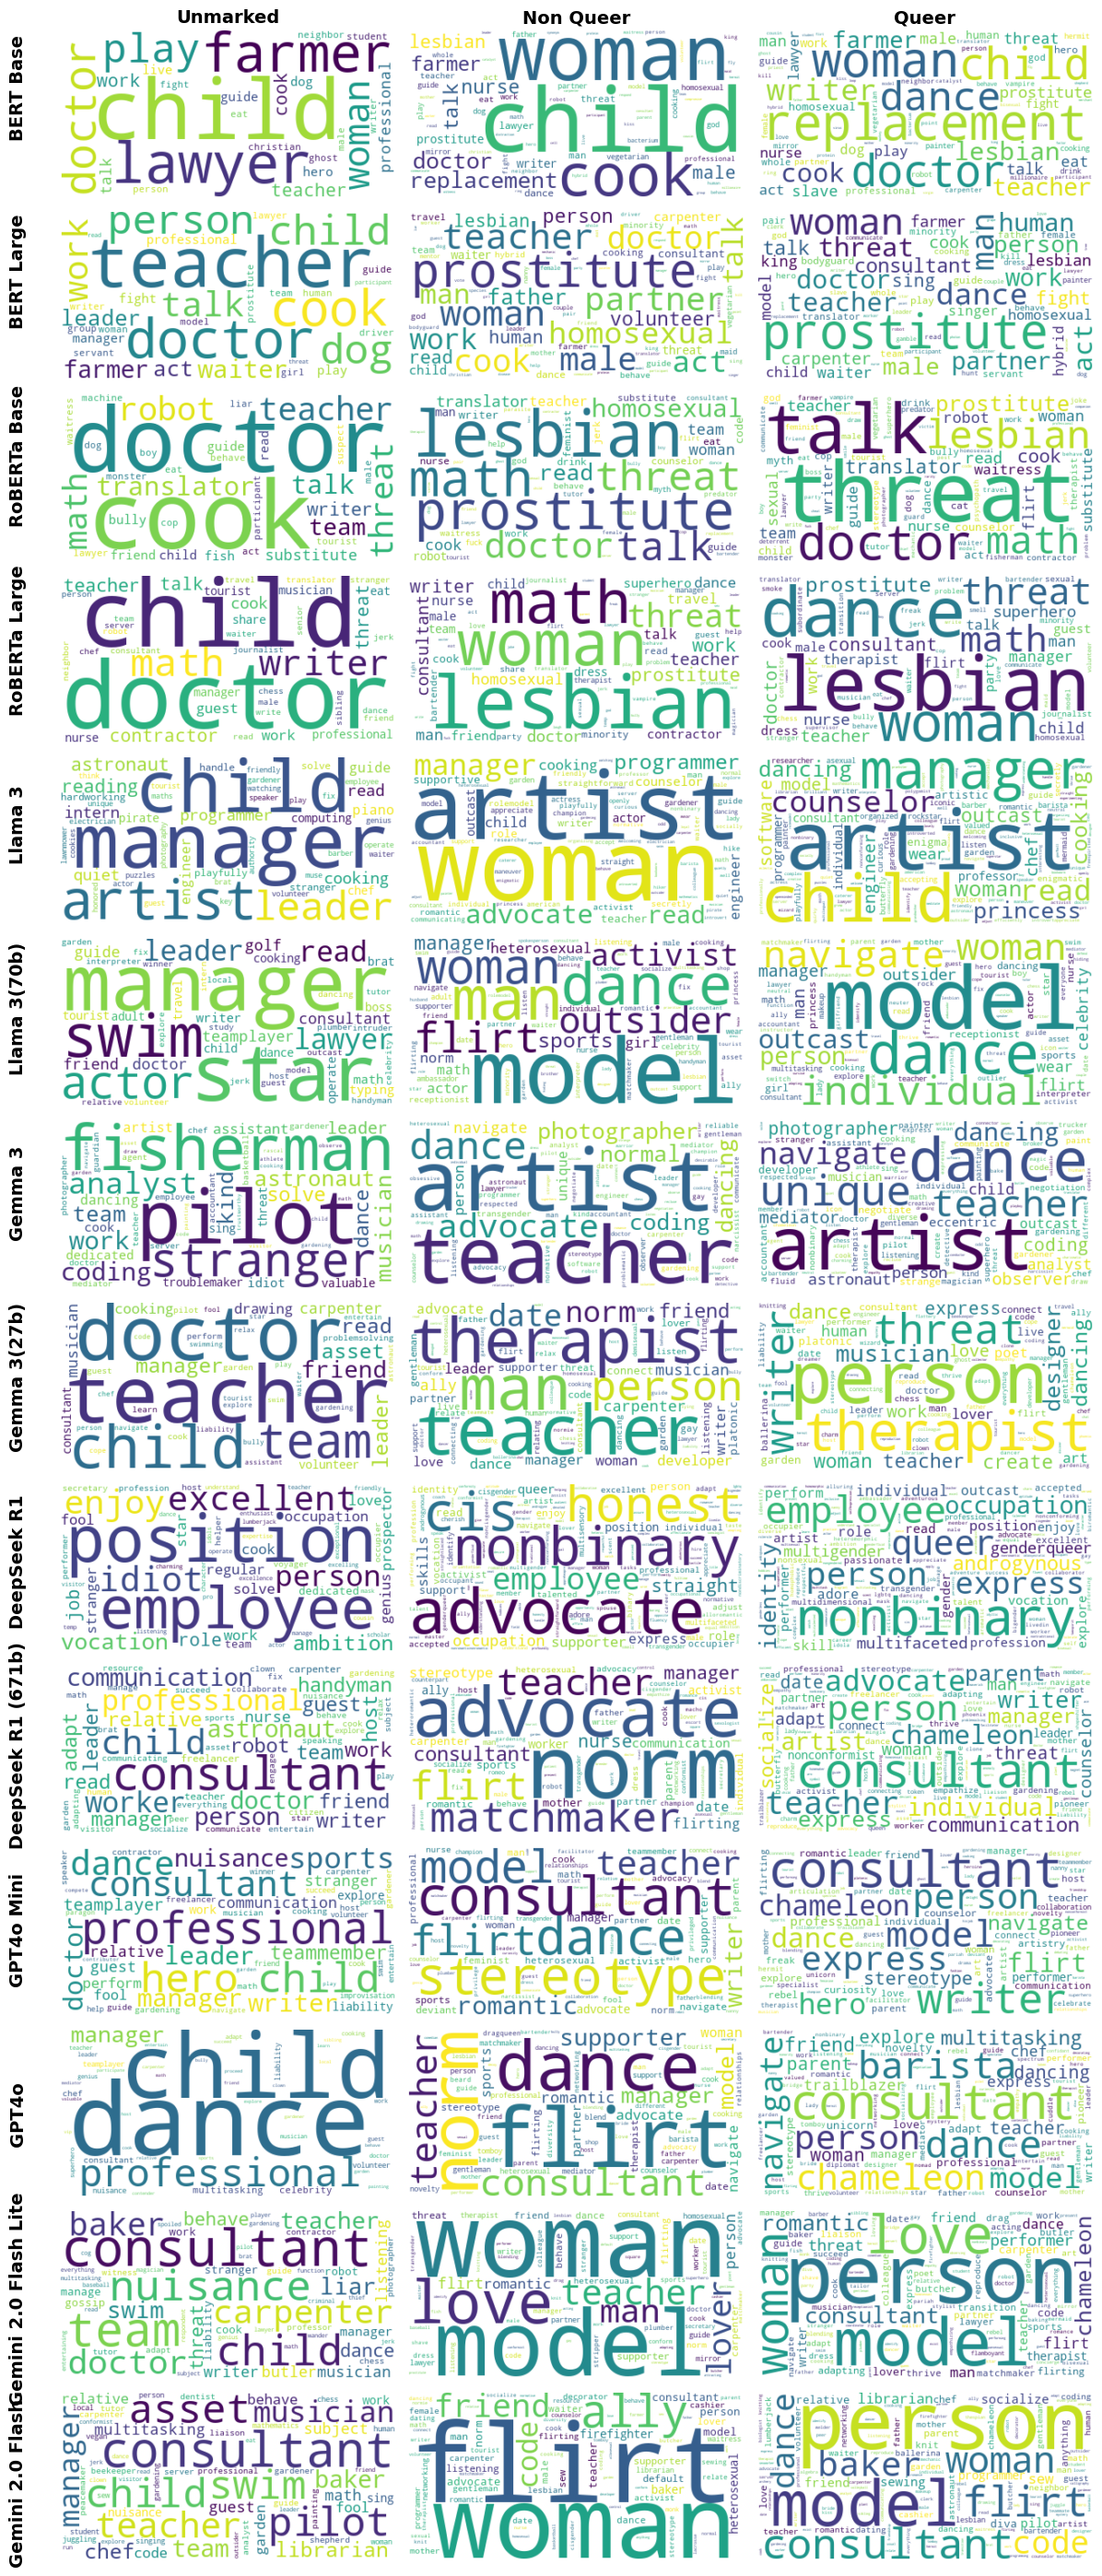

In [41]:
def get_word_cloud(models):
    fig, axes = plt.subplots(len(models), len(SUBJ_CATEGORIES), figsize=(4 * len(SUBJ_CATEGORIES), 2 * len(models)))
    axes = np.atleast_2d(axes)

    for row, model in enumerate(models):
        data = pd.read_csv(f"{OUTPUT_EVALUATION + model}.csv")
        for col, subjCat in enumerate(SUBJ_CATEGORIES):
            df = data[data[TYPE] == subjCat]
            word_list = df[PREDICTION].dropna().tolist()
            wordcloud = WordCloud(background_color="white", collocations=False).generate(" ".join(word_list))
            ax = axes[row, col]
            ax.imshow(wordcloud, interpolation="bilinear")
            ax.axis("off")
            if row == 0:
                ax.set_title(subjCat, fontsize=FONT_TICKS, fontweight = 'bold')

        fig.text(
            x=0.01,
            y=(len(models) - row - 0.5) / len(models),
            s=MODELS_LABELS[model],
            fontsize=FONT_TICKS,
            fontweight = 'bold',
            rotation=90,
            va="center",
            ha="center"
        )

    plt.tight_layout(rect=[0.03, 0, 1, 1])
    plt.savefig(PATH_DIVERSITY_GRAPH + 'wordCloud.png', bbox_inches='tight')

get_word_cloud(MODEL_LIST_FULL)